In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact

# **1. 학습 데이터 셋 클래스 만들기**

In [2]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))
train_data_df.head()

,file,emotion
0,angry_1.jpg,angry
1,angry_10.jpg,angry
2,angry_100.jpg,angry
3,angry_1000.jpg,angry
4,angry_1001.jpg,angry


In [6]:
'''
DataSet
ㄴ train
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
ㄴ valid
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
ㄴ test
  ㄴ angry
  ㄴ disgust
  ㄴ fear
  ㄴ happy
  ㄴ neutral
  ㄴ sad
  ㄴ surprise
'''
print(train_data_dir)

./DataSet/archive/train/


In [7]:
train_data_dir = './DataSet/archive/train/' # 상위 폴더 경로

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
IMAGE_SIZE = 48

In [9]:
### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수

def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [15]:
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image)
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [16]:
### 데이터가 잘 load되는지 확인하기

dset = Feeling_dataset(train_data_dir)

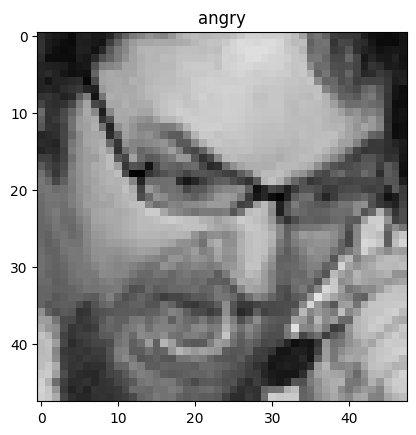

In [17]:
index = 0 # 제일 처음 사진 가져오기
plt.title(feelings_list[dset[index]['target']])
plt.imshow(dset[index]['image'])

# **2. 텐서 변환**

In [27]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    # 정규화
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225]) 
    # ImageNet이 학습한 수백만장의 이미지의 RGB 각각의 채널 값을 주로 default로 활용
])

In [28]:
train_dset = Feeling_dataset(train_data_dir,transformer)

In [33]:
### 데이터가 잘 변환되었는지 확인

index = 0
image = train_dset[index]['image']
feeling = train_dset[index]['target']

In [34]:
print(image.shape,feeling)

torch.Size([3, 48, 48]) tensor([0])


# **3. 데이터로더 구현**

In [35]:
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 4,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 1,shuffle = False,drop_last = False)
    
    return dataloaders

- batch_size에 대한 고려/ 수정 필요
- AutoML 등으로 hyper parameter tuning이 들어가야 하는 부분인가..?

In [36]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

In [37]:
for i,d in enumerate(dataloaders['train']):
    print(i,d)
    if i == 0:
        break

0 {'image': tensor([[[[-0.6452, -0.7137, -0.1999,  ..., -0.5596, -0.3369, -0.0458],
          [-1.1760, -0.4739,  0.0056,  ..., -0.6281, -0.3198, -0.0801],
          [-1.0048, -0.3027, -0.8849,  ..., -0.5767, -0.4397, -0.1314],
          ...,
          [-2.1179, -1.9295, -2.1179,  ..., -2.0323, -2.0837, -2.0152],
          [-2.0837, -2.0665, -1.9295,  ..., -2.0665, -1.9809, -1.8610],
          [-2.0665, -2.1179, -1.4672,  ..., -2.0665, -2.1179, -1.9638]],

         [[-0.5301, -0.6001, -0.0749,  ..., -0.4426, -0.2150,  0.0826],
          [-1.0728, -0.3550,  0.1352,  ..., -0.5126, -0.1975,  0.0476],
          [-0.8978, -0.1800, -0.7752,  ..., -0.4601, -0.3200, -0.0049],
          ...,
          [-2.0357, -1.8431, -2.0357,  ..., -1.9482, -2.0007, -1.9307],
          [-2.0007, -1.9832, -1.8431,  ..., -1.9832, -1.8957, -1.7731],
          [-1.9832, -2.0357, -1.3704,  ..., -1.9832, -2.0357, -1.8782]],

         [[-0.3055, -0.3753,  0.1476,  ..., -0.2184,  0.0082,  0.3045],
          [-0.8458

In [39]:
d['target'].shape

torch.Size([4, 1])

In [40]:
# squeeze(): size가 1인 차원 전체를 삭제

d['target'].squeeze()

tensor([0, 4, 5, 2])